# Usage

In this notebook we will see how to:
- cross-validate multiple binary classifiers;
- accumulate ground-truths and predictions
- assess calibration using the modelsight's `hosmer_lemeshow_plot` function.
- generate average ROC curves and test statistical significance of differences in AUCS between pairs of classifiers.

In [8]:
import os
import sys

sys.path.insert(0, os.path.abspath("../"))

## Miscellaneous

In [9]:
import random
import numpy as np
from dataclasses import dataclass, field
from numpy.random import SeedSequence, BitGenerator, Generator
from typing import Union, List, Tuple, Annotated, Literal, TypeVar, Optional
from sklearn.base import BaseEstimator  # type: ignore
from sklearn.model_selection._split import BaseCrossValidator, _RepeatedSplits

try:
    from numpy.typing import ArrayLike
except ImportError:
    ArrayLike = Union[np.ndarray, List[List[float]]]

if sys.version_info >= (3, 10):
    from typing import TypeAlias
else:
    from typing_extensions import TypeAlias


Estimator = TypeVar("Estimator", bound=BaseEstimator)
SeedType = Union[None, int, ArrayLike, SeedSequence, BitGenerator, Generator]
CVScheme: TypeAlias = TypeVar("CVScheme", BaseCrossValidator, _RepeatedSplits)


@dataclass
class CVModellingOutput:    
    gts_train: ArrayLike
    gts_val: ArrayLike
    gts_train_conc: ArrayLike
    gts_val_conc: ArrayLike

    # predicted probabilities
    probas_train: ArrayLike
    probas_val: ArrayLike
    probas_train_conc: ArrayLike
    probas_val_conc: ArrayLike
    
    # misc
    models: List[Estimator]
    errors: Optional[ArrayLike]
    correct: Optional[ArrayLike]
    features: Optional[ArrayLike]

class Colors:
    blue = "#4974a5"
    lightblue = "#b0c4de"
    salmon = "#ff8c69"
    lightsalmon = "#FFD1C2"
    darksalmon = "#e57e5e"

    green2 = "#82B240"
    charcoal = "#31485D"
    gray = "#A3BAC3"
    white = "#EAEBED"

    yellow = "#FFC325"
    red = "#E31B23"
    blue = "#005CAB"
    violet = "#9A348E"

## Load dataset

In this example, we will use the Breast Cancer Wisconsin dataset, which consists of features computed from a digitized image of a fine needle aspirate of a breast mass.
It's a binary classification problem where the dependent variable is the biopsy's outcome: M is malignant and B is benign.

We can load the dataset using `scikit-learn.datasets.load_breast_cancer`.

In [10]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

In [11]:
y.value_counts(normalize=True)

target
1    0.627417
0    0.372583
Name: proportion, dtype: float64

We can see that 62.7% of breast cancers were malignant.

In [12]:
X.isna().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

This is a toy dataset, hence it's super clean with no missing values.

## Train and validate model within a cross-validation scheme

In [13]:
import pandas as pd
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from interpret.glassbox import ExplainableBoostingClassifier

In [14]:
class BinaryModelFactory:
    def get_model(self, model_name: str) -> Estimator:
        if model_name == "EBM":
            return ExplainableBoostingClassifier(random_state=cv_config.get("SEED"),
                                        interactions=6,
                                        learning_rate=0.02,
                                        min_samples_leaf=5,
                                        n_jobs=-1)
        elif model_name == "LR":
            return LogisticRegression(penalty="elasticnet",
                                 solver="saga",
                                 l1_ratio=0.3,
                                 max_iter=10000,
                                 random_state=cv_config.get("SEED"))
        elif model_name == "SVC": 
            return SVC(probability=True, 
                   class_weight="balanced", 
                   random_state=cv_config.get("SEED"))
        elif model_name == "RF": 
            return RandomForestClassifier(random_state=cv_config.get("SEED"),
                                     n_estimators=5,
                                     max_depth=3,
                                     n_jobs=-1)
        elif model_name == "KNN": 
            return KNeighborsClassifier(n_jobs=-1)        
        else:
            raise ValueError(f"{model_name} is not a valid estimator name.")

In [15]:
def get_calibrated_model(model: Estimator, 
                         X: ArrayLike, y: ArrayLike) -> Estimator:
    """Calibrate an already fitted model using data X, y.

    Parameters
    ----------
    model : Estimator
        Already fitted model that should be calibrated
    X : ArrayLike
        Design matrix of n features and m observations.
    y : ArrayLike
        Array of m ground-truths

    Returns
    -------
    Estimator
        The calibrated model
    """
    calib_model = CalibratedClassifierCV(estimator=model,
                                         method="sigmoid",
                                         n_jobs=10,
                                         cv="prefit")
    calib_model.fit(X, y)
    
    return calib_model


def get_feature_selector(seed: SeedType) -> Estimator:
    fs = RandomForestClassifier(random_state=seed,
                                n_estimators=10,
                                max_depth=3,
                                n_jobs=4,
                                min_samples_leaf=2,
                                min_samples_split=3)
    return fs


def select_features(X: ArrayLike,
                    y: ArrayLike,
                    selector: Estimator,
                    cv: CVScheme,
                    scale: bool,
                    frac: float) -> set[str]:
    """Custom feature selection using a feature selector (in our case
    a Random Forest) and cross-validation. We select all features that
    are associated with a Gini impurity reduction at least 25% greater
    than the mean value.

    Parameters
    ----------
    X : ArrayLike
        An array of features values
    y : ArrayLike
        An array of ground truths
    selector : Estimator
        The feature selector. In our case is a Random Forest Classifier
        and we will use the built-in feature importances.
    cv : CVScheme
        A cross-validation scheme for selecting features.
    scale: bool
        Whether data should be scaled according to a StandardScaler
    frac: float
        Fraction of mean importance 

    Returns
    -------
    The set union of all selected features
    """
    inner_feature_sets = dict()

    for ji, (train_idxs_inner, _) in enumerate(cv.split(X, y)):
        # print(f"Inner split no. {ji+1}")
        inner_split = f"inner_split_{ji}"
        inner_feature_sets[inner_split] = set()

        # select inner training and validation folds
        X_train_inner = X.iloc[train_idxs_inner, :].copy()
        if not isinstance(y, pd.Series):
            y = pd.Series(y)

        y_train_inner = y.iloc[train_idxs_inner]

        # X_val_inner, y_val_inner = X.iloc[val_idxs_inner].copy(), y[val_idxs_inner]

        if scale:
            numeric_cols = X_train_inner.select_dtypes(
                include=[np.float64, np.int64]).columns.tolist()
            scaler = StandardScaler()
            X_train_inner.loc[:, numeric_cols] = scaler.fit_transform(
                X_train_inner.loc[:, numeric_cols])
            # X_val_inner.loc[:, numeric_cols] = scaler.transform(X_val_inner.loc[:, numeric_cols])

        # feature selection
        selected_features = set()

        feat_selector = clone(selector)
        feat_selector.fit(X_train_inner, y_train_inner)

        selected_features = list(map(lambda t: t[0], list(filter(
            lambda w: w[1] > frac*feat_selector.feature_importances_.mean(), zip(X.columns, feat_selector.feature_importances_)))))

        if not selected_features:
            continue

        # Check that each output feature is present in the dataset's columns.
        diff = set.difference(set(selected_features),
                              set(X_train_inner.columns))
        if diff:
            raise ValueError(
                F"Could not find features {DIFF} in the dataframe.")

        if not isinstance(selected_features, set):
            selected_features = set(selected_features)

        inner_feature_sets[inner_split] = selected_features

    return sorted(set.union(*inner_feature_sets.values()))

In [18]:
cv_config = {
    "N_REPEATS": 2,
    "N_SPLITS": 10,
    "SHUFFLE": True,
    "SCALE": False,
    "CALIBRATE": True,
    "CALIB_FRACTION": 0.15,
    "SEED": 1303
}

outer_cv = RepeatedStratifiedKFold(n_repeats=cv_config.get("N_REPEATS"),
                                   n_splits=cv_config.get("N_SPLITS"),
                                   random_state=cv_config.get("SEED"))

inner_cv = StratifiedKFold(n_splits=cv_config.get("N_SPLITS"),
                           shuffle=cv_config.get("SHUFFLE"),
                           random_state=cv_config.get("SEED"))

models_names = ["EBM", "LR", "SVC", "RF", "KNN"]

model_factory = BinaryModelFactory()
cv_results = dict()

for model_name in models_names:
    print(f"Processing model {model_name}\n")

    gts_train = []
    gts_val = []
    probas_train = []
    probas_val = []
    gts_train_conc = []
    gts_val_conc = []
    probas_train_conc = []
    probas_val_conc = []

    models = []
    errors = []
    correct = []
    features = []
        
    for i, (train_idx, val_idx) in enumerate(outer_cv.split(X, y)):
        Xtemp, ytemp = X.iloc[train_idx, :], y.iloc[train_idx]
        Xval, yval = X.iloc[val_idx, :], y.iloc[val_idx]

        if cv_config.get("CALIBRATE"):
            Xtrain, Xcal, ytrain, ycal = train_test_split(Xtemp, ytemp,
                                                          test_size=cv_config.get(
                                                              "CALIB_FRACTION"),
                                                          stratify=ytemp,
                                                          random_state=cv_config.get("SEED"))
        else:
            Xtrain, ytrain = Xtemp, ytemp

        model = model_factory.get_model(model_name)

        # select features
        feat_subset = select_features(Xtrain, ytrain,
                                      selector=get_feature_selector(
                                          cv_config.get("SEED")),
                                      cv=inner_cv,
                                      scale=False,
                                      frac=1.25)
        features.append(feat_subset)

        if cv_config.get("SCALE"):
            numeric_cols = Xtrain.select_dtypes(
                include=[np.float64, np.int64]).columns.tolist()
            scaler = StandardScaler()
            Xtrain.loc[:, numeric_cols] = scaler.fit_transform(
                Xtrain.loc[:, numeric_cols])
            Xtest.loc[:, numeric_cols] = scaler.transform(
                Xtest.loc[:, numeric_cols])

        model.fit(Xtrain.loc[:, feat_subset], ytrain)

        if cv_config.get("CALIBRATE"):
            model = get_calibrated_model(model,
                                         X=Xcal.loc[:, feat_subset],
                                         y=ycal)

        models.append(model)

        # accumulate ground-truths
        gts_train.append(ytrain)
        gts_val.append(yval)

        # accumulate predictions
        train_pred_probas = model.predict_proba(Xtrain.loc[:, feat_subset])[:, 1]
        val_pred_probas = model.predict_proba(Xval.loc[:, feat_subset])[:, 1]

        probas_train.append(train_pred_probas)
        probas_val.append(val_pred_probas)

        # identify correct and erroneous predictions according to the
        # classification cut-off that maximizes the Youden's J index
        fpr, tpr, thresholds = roc_curve(ytrain, train_pred_probas)
        idx = np.argmax(tpr - fpr)
        youden = thresholds[idx]

        labels_val = np.where(val_pred_probas >= youden, 1, 0)

        # indexes of validation instances misclassified by the model
        error_idxs = Xval[(yval != labels_val)].index
        errors.append(error_idxs)

        # indexes of correct predictions
        correct.append(Xval[(yval == labels_val)].index)

    # CV results for current model
    curr_est_results = CVModellingOutput(
        gts_train=gts_train,
        gts_val=gts_val,
        probas_train=probas_train,
        probas_val=probas_val,
        gts_train_conc=np.concatenate(gts_train),
        gts_val_conc=np.concatenate(gts_val),
        probas_train_conc=np.concatenate(probas_train),
        probas_val_conc=np.concatenate(probas_val),
        models=models,
        errors=errors,
        correct=correct,
        features=features
    )
    
    cv_results[model_name] = curr_est_results

Processing model EBM

Processing model LR

Processing model SVC

Processing model RF

Processing model KNN



## Average ROC curves

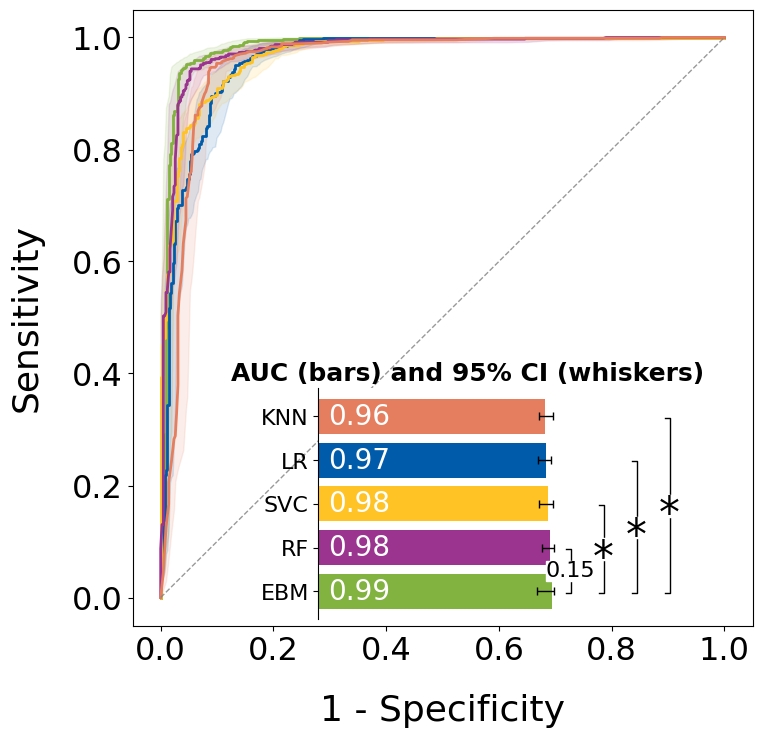

In [45]:
import matplotlib.pyplot as plt
from modelsight.curves import average_roc_curves, roc_comparisons, add_annotations


model_names = list(cv_results.keys())
alpha = 0.05
alph_str = str(alpha).split(".")[1]
alpha_formatted = f".{alph_str}"
roc_symbol = "*"
palette = [Colors.green2, Colors.blue, Colors.yellow, Colors.violet, Colors.darksalmon]
n_boot = 100

f, ax = plt.subplots(1, 1, figsize=(8, 8))

kwargs = dict()

f, ax, barplot, bars, all_data = average_roc_curves(cv_results,
                                                    colors=palette,
                                                    model_keys=model_names,
                                                    show_ci=True,
                                                    n_boot=n_boot,
                                                    bars_pos=[
                                                        0.3, 0.01, 0.6, 0.075*len(model_names)],
                                                    random_state=cv_config.get("SEED"),
                                                    ax=ax,
                                                    **kwargs)

roc_comparisons_results = roc_comparisons(cv_results, "EBM")

kwargs = dict(space_between_whiskers = 0.07)
order = [
    ("EBM", "RF"),
    ("EBM", "SVC"),
    ("EBM", "LR"),
    ("EBM", "KNN")
]
ax_annot = add_annotations(roc_comparisons_results, 
                  alpha = 0.05, 
                  bars=bars, 
                  direction = "vertical",
                  order = order,
                  symbol = roc_symbol,
                  symbol_fontsize = 30,
                  voffset = -0.05,
                  ext_voffset=0,
                  ext_hoffset=0,
                  ax=barplot,
                  **kwargs)


#plt.savefig("roc.png", dpi=300, bbox_inches='tight')
plt.show()

## Model calibration

We will now compute median Brier score (95% CI) of the ExplainableBoostingClassifier and use it to annotate the calibration plot.

In [24]:
from sklearn.metrics import brier_score_loss
briers = []
for gt, preds in zip(cv_results["EBM"].gts_val, cv_results["EBM"].probas_val):
    brier = brier_score_loss(gt, preds)
    briers.append(brier)

brier_low, brier_med, brier_up = np.percentile(briers, [2.5, 50, 97.5])

brier_annot = f"{brier_med:.2f} ({brier_low:.2f} - {brier_up:.2f})"

Let's see how well calibrated are the predicted probabilities

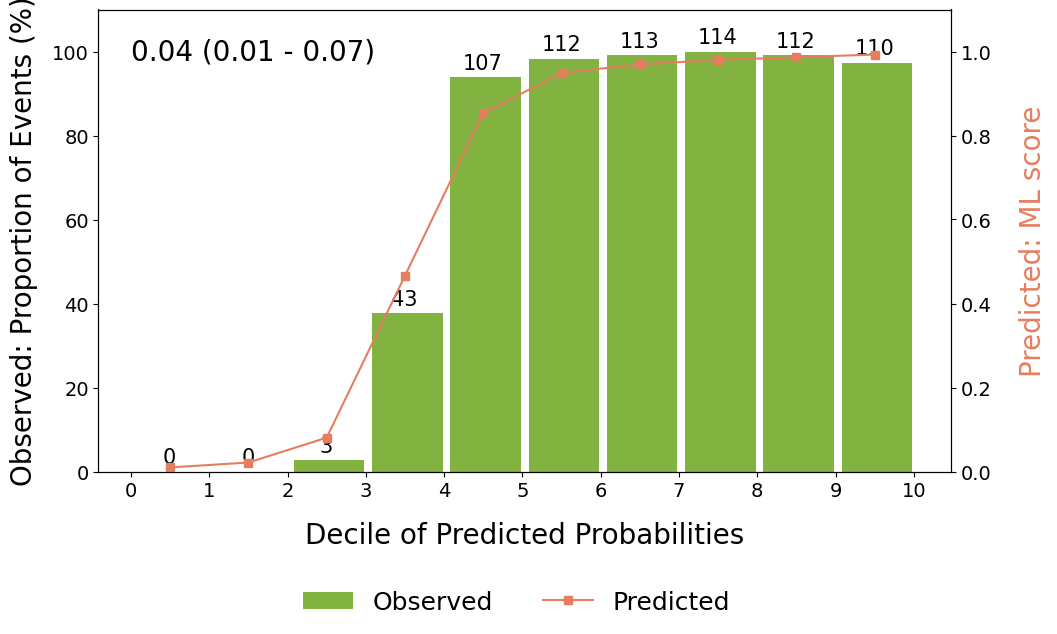

In [46]:
import matplotlib.pyplot as plt
from modelsight.calibration import hosmer_lemeshow_plot

f, ax = plt.subplots(1, 1, figsize=(11,6))

f, ax = hosmer_lemeshow_plot(cv_results["EBM"].gts_val_conc,
                             cv_results["EBM"].probas_val_conc,
                             n_bins=10,
                             colors=(Colors.darksalmon, Colors.green2),
                             annotate_bars=True,
                             title="",
                             brier_score_annot=brier_annot,
                             ax=ax
                             )

#plt.savefig("calib.png", dpi=300, bbox_inches='tight')
plt.show()

The model appears to be perfectly calibrated, as predicted probabilites match observed ones.

Median brier score is also very low, indicating a good, calibrated classifier.